In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from baselines.tcn import TCN

2023-07-22 22:07:20.060459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 22:07:21.764155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

### Parameters

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9


# ===== model parameters ======
nb_filters = 32
kernel_size = 2
dropout = 0.2
dense_units1 = 128
dense_units2 = 64
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [5]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


In [7]:
train_X_mask = train_X_mask[:, :n_hours, :]
val_X_mask = val_X_mask[:, :n_hours, :]
test_X_mask = test_X_mask[:, :n_hours, :]

In [8]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 72, 16) (9634, 72, 16) (19268, 72, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [9]:
inputs = Input(shape=(train_X_mask.shape[1], train_X_mask.shape[2]))
masked_inputs = Masking(mask_value=masked_value)(inputs)

tcn = TCN(nb_filters=nb_filters,
          kernel_size=kernel_size,
          use_batch_norm=False,
          use_weight_norm=False,
          use_layer_norm=True,
          return_sequences=True,
          dropout_rate=dropout,
          activation='relu', 
          input_shape=(train_X_mask.shape[1], train_X_mask.shape[2])
         )(masked_inputs)
x = Dense(32)(tcn)
x = Dropout(dropout)(x)
x = Flatten()(x)
outputs = Dense(96)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

2023-07-22 22:07:53.680961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:88:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 16)]          0         
                                                                 
 masking (Masking)           (None, 72, 16)            0         
                                                                 
 tcn (TCN)                   (None, 72, 32)            25248     
                                                                 
 dense (Dense)               (None, 72, 32)            1056      
                                                                 
 dropout (Dropout)           (None, 72, 32)            0         
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense_1 (Dense)             (None, 96)                221280

In [10]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/tcn_gate_pump_nofuture.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'TCN': TCN},
                     save_best_only=True
                    )


model.fit(train_X_mask, train_ws_y,
          validation_data=(test_X_mask, test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 22:08:06.456253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-22 22:08:07.858316: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efac0008390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 22:08:07.858375: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 22:08:07.868857: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 22:08:08.282261: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.33895, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 30s - loss: 4.8348 - mae: 1.6917 - val_loss: 0.1858 - val_mae: 0.3389 - 30s/epoch - 200ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.33895 to 0.25262, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 1.6170 - mae: 1.0020 - val_loss: 0.1005 - val_mae: 0.2526 - 9s/epoch - 60ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.25262 to 0.22879, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 0.8473 - mae: 0.7260 - val_loss: 0.0821 - val_mae: 0.2288 - 9s/epoch - 61ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.22879 to 0.22034, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 0.5594 - mae: 0.5890 - val_loss: 0.0743 - val_mae: 0.2203 - 9s/epoch - 61ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.22034 to 0.21568, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 0.4234 - mae: 0.5119 - val_loss: 0.0695 - val_mae: 0.2157 - 9s/epoch - 61ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.21568 to 0.20643, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/1

151/151 - 9s - loss: 0.0126 - mae: 0.0871 - val_loss: 0.0152 - val_mae: 0.1026 - 9s/epoch - 61ms/step
Epoch 41/3000

Epoch 41: val_mae improved from 0.10261 to 0.09850, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 0.0117 - mae: 0.0840 - val_loss: 0.0142 - val_mae: 0.0985 - 9s/epoch - 61ms/step
Epoch 42/3000

Epoch 42: val_mae improved from 0.09850 to 0.09337, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 0.0109 - mae: 0.0809 - val_loss: 0.0129 - val_mae: 0.0934 - 9s/epoch - 61ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.09337 to 0.08993, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 0.0101 - mae: 0.0780 - val_loss: 0.0121 - val_mae: 0.0899 - 9s/epoch - 61ms/step
Epoch 44/3000

Epoch 44: val_mae did not improve from 0.08993
151/151 - 9s - loss: 0.0094 - mae: 0.0752 - val_loss: 0.0120 - val_mae: 0.0900 - 9s/epoch - 60ms/step
Epoch 45/3000

Epoch 45: val_mae improved from 0.08993 to 0.08

Epoch 80/3000

Epoch 80: val_mae did not improve from 0.04498
151/151 - 9s - loss: 0.0016 - mae: 0.0307 - val_loss: 0.0034 - val_mae: 0.0450 - 9s/epoch - 60ms/step
Epoch 81/3000

Epoch 81: val_mae did not improve from 0.04498
151/151 - 9s - loss: 0.0016 - mae: 0.0303 - val_loss: 0.0035 - val_mae: 0.0455 - 9s/epoch - 60ms/step
Epoch 82/3000

Epoch 82: val_mae improved from 0.04498 to 0.04474, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 0.0015 - mae: 0.0299 - val_loss: 0.0033 - val_mae: 0.0447 - 9s/epoch - 62ms/step
Epoch 83/3000

Epoch 83: val_mae improved from 0.04474 to 0.04438, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 0.0015 - mae: 0.0295 - val_loss: 0.0033 - val_mae: 0.0444 - 9s/epoch - 61ms/step
Epoch 84/3000

Epoch 84: val_mae did not improve from 0.04438
151/151 - 9s - loss: 0.0015 - mae: 0.0291 - val_loss: 0.0034 - val_mae: 0.0452 - 9s/epoch - 60ms/step
Epoch 85/3000

Epoch 85: val_mae improved from 0.04438 to 0.

151/151 - 9s - loss: 8.7908e-04 - mae: 0.0219 - val_loss: 0.0021 - val_mae: 0.0362 - 9s/epoch - 59ms/step
Epoch 123/3000

Epoch 123: val_mae did not improve from 0.03623
151/151 - 9s - loss: 8.7399e-04 - mae: 0.0218 - val_loss: 0.0023 - val_mae: 0.0378 - 9s/epoch - 58ms/step
Epoch 124/3000

Epoch 124: val_mae improved from 0.03623 to 0.03609, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 8.6415e-04 - mae: 0.0217 - val_loss: 0.0021 - val_mae: 0.0361 - 9s/epoch - 59ms/step
Epoch 125/3000

Epoch 125: val_mae did not improve from 0.03609
151/151 - 9s - loss: 8.5894e-04 - mae: 0.0216 - val_loss: 0.0022 - val_mae: 0.0369 - 9s/epoch - 58ms/step
Epoch 126/3000

Epoch 126: val_mae improved from 0.03609 to 0.03604, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 8.5209e-04 - mae: 0.0215 - val_loss: 0.0021 - val_mae: 0.0360 - 9s/epoch - 59ms/step
Epoch 127/3000

Epoch 127: val_mae did not improve from 0.03604
151/151 - 9s - loss: 8.5015e-0

Epoch 166/3000

Epoch 166: val_mae did not improve from 0.03378
151/151 - 9s - loss: 7.2030e-04 - mae: 0.0197 - val_loss: 0.0019 - val_mae: 0.0341 - 9s/epoch - 58ms/step
Epoch 167/3000

Epoch 167: val_mae did not improve from 0.03378
151/151 - 9s - loss: 7.1890e-04 - mae: 0.0196 - val_loss: 0.0019 - val_mae: 0.0348 - 9s/epoch - 58ms/step
Epoch 168/3000

Epoch 168: val_mae did not improve from 0.03378
151/151 - 9s - loss: 7.1965e-04 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0339 - 9s/epoch - 58ms/step
Epoch 169/3000

Epoch 169: val_mae did not improve from 0.03378
151/151 - 9s - loss: 7.1612e-04 - mae: 0.0196 - val_loss: 0.0019 - val_mae: 0.0344 - 9s/epoch - 58ms/step
Epoch 170/3000

Epoch 170: val_mae improved from 0.03378 to 0.03359, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 7.1365e-04 - mae: 0.0196 - val_loss: 0.0018 - val_mae: 0.0336 - 9s/epoch - 59ms/step
Epoch 171/3000

Epoch 171: val_mae did not improve from 0.03359
151/151 - 9s - loss: 7.148

Epoch 213/3000

Epoch 213: val_mae did not improve from 0.03299
151/151 - 9s - loss: 6.7148e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0340 - 9s/epoch - 58ms/step
Epoch 214/3000

Epoch 214: val_mae did not improve from 0.03299
151/151 - 9s - loss: 6.7169e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0336 - 9s/epoch - 58ms/step
Epoch 215/3000

Epoch 215: val_mae did not improve from 0.03299
151/151 - 9s - loss: 6.6792e-04 - mae: 0.0189 - val_loss: 0.0018 - val_mae: 0.0340 - 9s/epoch - 58ms/step
Epoch 216/3000

Epoch 216: val_mae did not improve from 0.03299
151/151 - 9s - loss: 6.7159e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0335 - 9s/epoch - 58ms/step
Epoch 217/3000

Epoch 217: val_mae did not improve from 0.03299
151/151 - 9s - loss: 6.6716e-04 - mae: 0.0189 - val_loss: 0.0018 - val_mae: 0.0336 - 9s/epoch - 58ms/step
Epoch 218/3000

Epoch 218: val_mae did not improve from 0.03299
151/151 - 9s - loss: 6.6733e-04 - mae: 0.0189 - val_loss: 0.0017 - val_mae: 0.0332 - 9

Epoch 261/3000

Epoch 261: val_mae did not improve from 0.03286
151/151 - 9s - loss: 6.4020e-04 - mae: 0.0186 - val_loss: 0.0018 - val_mae: 0.0333 - 9s/epoch - 58ms/step
Epoch 262/3000

Epoch 262: val_mae did not improve from 0.03286
151/151 - 9s - loss: 6.3989e-04 - mae: 0.0185 - val_loss: 0.0017 - val_mae: 0.0329 - 9s/epoch - 58ms/step
Epoch 263/3000

Epoch 263: val_mae did not improve from 0.03286
151/151 - 9s - loss: 6.4130e-04 - mae: 0.0185 - val_loss: 0.0017 - val_mae: 0.0332 - 9s/epoch - 58ms/step
Epoch 264/3000

Epoch 264: val_mae did not improve from 0.03286
151/151 - 9s - loss: 6.3948e-04 - mae: 0.0185 - val_loss: 0.0017 - val_mae: 0.0330 - 9s/epoch - 58ms/step
Epoch 265/3000

Epoch 265: val_mae did not improve from 0.03286
151/151 - 9s - loss: 6.3908e-04 - mae: 0.0185 - val_loss: 0.0018 - val_mae: 0.0338 - 9s/epoch - 58ms/step
Epoch 266/3000

Epoch 266: val_mae did not improve from 0.03286
151/151 - 9s - loss: 6.3664e-04 - mae: 0.0185 - val_loss: 0.0017 - val_mae: 0.0330 - 9

151/151 - 9s - loss: 6.1966e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0328 - 9s/epoch - 58ms/step
Epoch 309/3000

Epoch 309: val_mae did not improve from 0.03210
151/151 - 9s - loss: 6.1771e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0330 - 9s/epoch - 58ms/step
Epoch 310/3000

Epoch 310: val_mae did not improve from 0.03210
151/151 - 9s - loss: 6.1800e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0325 - 9s/epoch - 58ms/step
Epoch 311/3000

Epoch 311: val_mae did not improve from 0.03210
151/151 - 9s - loss: 6.1855e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0325 - 9s/epoch - 58ms/step
Epoch 312/3000

Epoch 312: val_mae did not improve from 0.03210
151/151 - 9s - loss: 6.1653e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0329 - 9s/epoch - 58ms/step
Epoch 313/3000

Epoch 313: val_mae did not improve from 0.03210
151/151 - 9s - loss: 6.1491e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0323 - 9s/epoch - 58ms/step
Epoch 314/3000

Epoch 314: val_mae did not i

Epoch 356/3000

Epoch 356: val_mae did not improve from 0.03187
151/151 - 9s - loss: 6.0388e-04 - mae: 0.0180 - val_loss: 0.0016 - val_mae: 0.0321 - 9s/epoch - 58ms/step
Epoch 357/3000

Epoch 357: val_mae did not improve from 0.03187
151/151 - 9s - loss: 6.0246e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0323 - 9s/epoch - 58ms/step
Epoch 358/3000

Epoch 358: val_mae did not improve from 0.03187
151/151 - 9s - loss: 6.0453e-04 - mae: 0.0180 - val_loss: 0.0016 - val_mae: 0.0319 - 9s/epoch - 57ms/step
Epoch 359/3000

Epoch 359: val_mae improved from 0.03187 to 0.03175, saving model to saved_models/tcn_gate_pump_nofuture.h5
151/151 - 9s - loss: 6.0184e-04 - mae: 0.0180 - val_loss: 0.0016 - val_mae: 0.0318 - 9s/epoch - 58ms/step
Epoch 360/3000

Epoch 360: val_mae did not improve from 0.03175
151/151 - 9s - loss: 6.0232e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0322 - 9s/epoch - 58ms/step
Epoch 361/3000

Epoch 361: val_mae did not improve from 0.03175
151/151 - 9s - loss: 6.020

Epoch 403/3000

Epoch 403: val_mae did not improve from 0.03149
151/151 - 9s - loss: 5.9219e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0318 - 9s/epoch - 58ms/step
Epoch 404/3000

Epoch 404: val_mae did not improve from 0.03149
151/151 - 9s - loss: 5.9062e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 405/3000

Epoch 405: val_mae did not improve from 0.03149
151/151 - 9s - loss: 5.8946e-04 - mae: 0.0178 - val_loss: 0.0017 - val_mae: 0.0321 - 9s/epoch - 58ms/step
Epoch 406/3000

Epoch 406: val_mae did not improve from 0.03149
151/151 - 9s - loss: 5.8712e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 407/3000

Epoch 407: val_mae did not improve from 0.03149
151/151 - 9s - loss: 5.9115e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 408/3000

Epoch 408: val_mae did not improve from 0.03149
151/151 - 9s - loss: 5.9032e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0316 - 9

Epoch 450/3000

Epoch 450: val_mae did not improve from 0.03113
151/151 - 9s - loss: 5.8040e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 451/3000

Epoch 451: val_mae did not improve from 0.03113
151/151 - 9s - loss: 5.8151e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0319 - 9s/epoch - 58ms/step
Epoch 452/3000

Epoch 452: val_mae did not improve from 0.03113
151/151 - 9s - loss: 5.7998e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 57ms/step
Epoch 453/3000

Epoch 453: val_mae did not improve from 0.03113
151/151 - 9s - loss: 5.8137e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 57ms/step
Epoch 454/3000

Epoch 454: val_mae did not improve from 0.03113
151/151 - 9s - loss: 5.7926e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 455/3000

Epoch 455: val_mae did not improve from 0.03113
151/151 - 9s - loss: 5.7924e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0318 - 9

Epoch 498/3000

Epoch 498: val_mae did not improve from 0.03103
151/151 - 9s - loss: 5.7166e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0314 - 9s/epoch - 57ms/step
Epoch 499/3000

Epoch 499: val_mae did not improve from 0.03103
151/151 - 9s - loss: 5.7133e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 500/3000

Epoch 500: val_mae did not improve from 0.03103
151/151 - 9s - loss: 5.7067e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0318 - 9s/epoch - 58ms/step
Epoch 501/3000

Epoch 501: val_mae did not improve from 0.03103
151/151 - 9s - loss: 5.7191e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 502/3000

Epoch 502: val_mae did not improve from 0.03103
151/151 - 9s - loss: 5.7002e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 503/3000

Epoch 503: val_mae did not improve from 0.03103
151/151 - 9s - loss: 5.7207e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0313 - 9

Epoch 546/3000

Epoch 546: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.6575e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 547/3000

Epoch 547: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.6455e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 548/3000

Epoch 548: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.6428e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 549/3000

Epoch 549: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.6410e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 550/3000

Epoch 550: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.6465e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 551/3000

Epoch 551: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.6447e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0312 - 9

151/151 - 9s - loss: 5.5677e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 595/3000

Epoch 595: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.5975e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 596/3000

Epoch 596: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.5776e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 597/3000

Epoch 597: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.5925e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 598/3000

Epoch 598: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.5915e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 599/3000

Epoch 599: val_mae did not improve from 0.03091
151/151 - 9s - loss: 5.5823e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 600/3000

Epoch 600: val_mae did not i

151/151 - 9s - loss: 5.5223e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0309 - 9s/epoch - 58ms/step
Epoch 643/3000

Epoch 643: val_mae did not improve from 0.03090
151/151 - 9s - loss: 5.5265e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 644/3000

Epoch 644: val_mae did not improve from 0.03090
151/151 - 9s - loss: 5.5213e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 645/3000

Epoch 645: val_mae did not improve from 0.03090
151/151 - 9s - loss: 5.5284e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 646/3000

Epoch 646: val_mae did not improve from 0.03090
151/151 - 9s - loss: 5.5308e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 647/3000

Epoch 647: val_mae did not improve from 0.03090
151/151 - 9s - loss: 5.5209e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 648/3000

Epoch 648: val_mae did not i

Epoch 690/3000

Epoch 690: val_mae did not improve from 0.03081
151/151 - 9s - loss: 5.4650e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 691/3000

Epoch 691: val_mae did not improve from 0.03081
151/151 - 9s - loss: 5.4692e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 692/3000

Epoch 692: val_mae did not improve from 0.03081
151/151 - 9s - loss: 5.4665e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 693/3000

Epoch 693: val_mae did not improve from 0.03081
151/151 - 9s - loss: 5.4710e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 694/3000

Epoch 694: val_mae did not improve from 0.03081
151/151 - 9s - loss: 5.4697e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 695/3000

Epoch 695: val_mae did not improve from 0.03081
151/151 - 9s - loss: 5.4533e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0310 - 9

Epoch 738/3000

Epoch 738: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.4327e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 739/3000

Epoch 739: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.4191e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 740/3000

Epoch 740: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.4302e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0310 - 9s/epoch - 58ms/step
Epoch 741/3000

Epoch 741: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.4320e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0310 - 9s/epoch - 58ms/step
Epoch 742/3000

Epoch 742: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.4262e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 743/3000

Epoch 743: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.4188e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0311 - 9

151/151 - 9s - loss: 5.3757e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 787/3000

Epoch 787: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3851e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 788/3000

Epoch 788: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3860e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0311 - 9s/epoch - 58ms/step
Epoch 789/3000

Epoch 789: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3717e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 790/3000

Epoch 790: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3767e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0314 - 9s/epoch - 58ms/step
Epoch 791/3000

Epoch 791: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3926e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 792/3000

Epoch 792: val_mae did not i

Epoch 835/3000

Epoch 835: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3631e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 836/3000

Epoch 836: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3374e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0312 - 9s/epoch - 58ms/step
Epoch 837/3000

Epoch 837: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3404e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 838/3000

Epoch 838: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3351e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 57ms/step
Epoch 839/3000

Epoch 839: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3554e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 840/3000

Epoch 840: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3537e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0314 - 9

151/151 - 9s - loss: 5.3229e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 884/3000

Epoch 884: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3084e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 885/3000

Epoch 885: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3267e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0314 - 9s/epoch - 58ms/step
Epoch 886/3000

Epoch 886: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3021e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 887/3000

Epoch 887: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3185e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 888/3000

Epoch 888: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.3100e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0314 - 9s/epoch - 58ms/step
Epoch 889/3000

Epoch 889: val_mae did not i

Epoch 932/3000

Epoch 932: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2785e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 933/3000

Epoch 933: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2755e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 934/3000

Epoch 934: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2710e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 935/3000

Epoch 935: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2719e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 936/3000

Epoch 936: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2857e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 937/3000

Epoch 937: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2757e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0316 - 9

151/151 - 9s - loss: 5.2500e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0318 - 9s/epoch - 58ms/step
Epoch 981/3000

Epoch 981: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2436e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 982/3000

Epoch 982: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2480e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 983/3000

Epoch 983: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2387e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 984/3000

Epoch 984: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2619e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0314 - 9s/epoch - 58ms/step
Epoch 985/3000

Epoch 985: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2483e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 986/3000

Epoch 986: val_mae did not i

151/151 - 9s - loss: 5.2388e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 1029/3000

Epoch 1029: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2226e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 1030/3000

Epoch 1030: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2319e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 1031/3000

Epoch 1031: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2278e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 1032/3000

Epoch 1032: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2252e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 1033/3000

Epoch 1033: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2132e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 1034/3000

Epoch 1034: val_m


Epoch 1076: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1968e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 1077/3000

Epoch 1077: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2090e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0315 - 9s/epoch - 58ms/step
Epoch 1078/3000

Epoch 1078: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2097e-04 - mae: 0.0167 - val_loss: 0.0017 - val_mae: 0.0320 - 9s/epoch - 58ms/step
Epoch 1079/3000

Epoch 1079: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1934e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 1080/3000

Epoch 1080: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.2084e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0313 - 9s/epoch - 58ms/step
Epoch 1081/3000

Epoch 1081: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1990e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/ep

Epoch 1124/3000

Epoch 1124: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1780e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0318 - 9s/epoch - 58ms/step
Epoch 1125/3000

Epoch 1125: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1958e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 1126/3000

Epoch 1126: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1694e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 1127/3000

Epoch 1127: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1814e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 1128/3000

Epoch 1128: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1608e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0314 - 9s/epoch - 58ms/step
Epoch 1129/3000

Epoch 1129: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1716e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae

Epoch 1172/3000

Epoch 1172: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1550e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0317 - 9s/epoch - 58ms/step
Epoch 1173/3000

Epoch 1173: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1564e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0318 - 9s/epoch - 58ms/step
Epoch 1174/3000

Epoch 1174: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1564e-04 - mae: 0.0166 - val_loss: 0.0017 - val_mae: 0.0319 - 9s/epoch - 58ms/step
Epoch 1175/3000

Epoch 1175: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1551e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0318 - 9s/epoch - 58ms/step
Epoch 1176/3000

Epoch 1176: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1533e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0316 - 9s/epoch - 58ms/step
Epoch 1177/3000

Epoch 1177: val_mae did not improve from 0.03074
151/151 - 9s - loss: 5.1560e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae

### Performance

In [11]:
saved_model = load_model('saved_models/tcn_gate_pump_nofuture.h5', custom_objects={'TCN': TCN})

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 4s 5ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.1625
RMSE = 0.2076


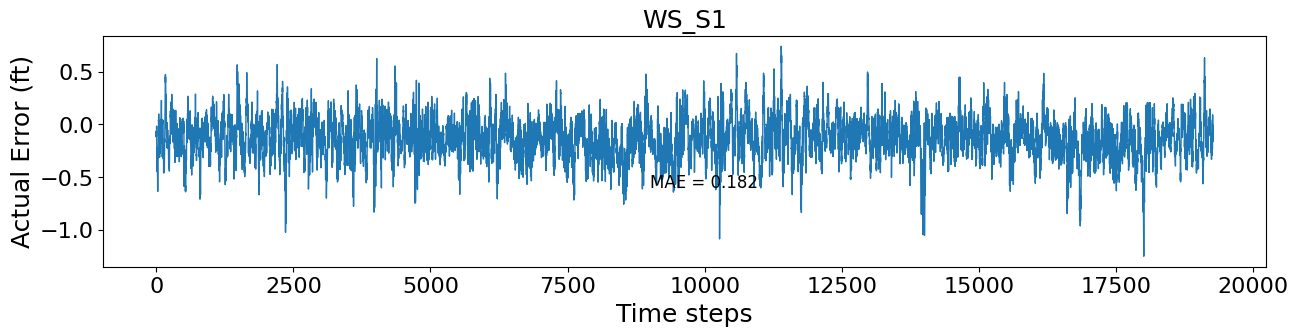

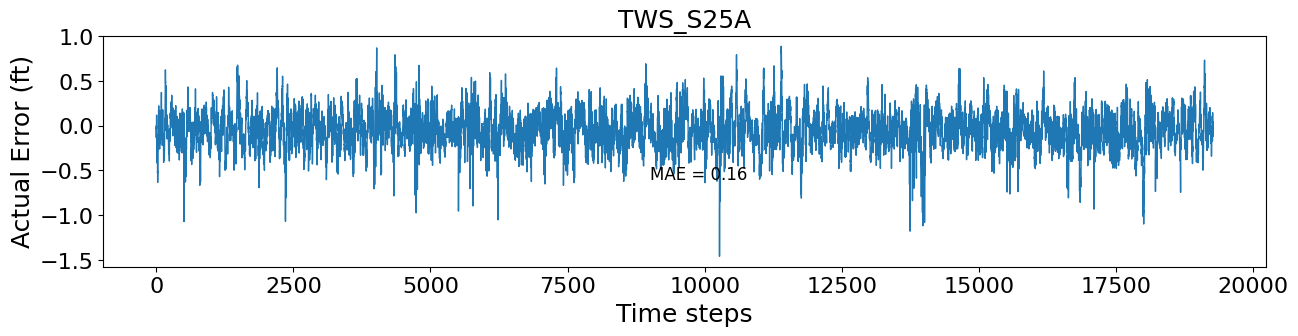

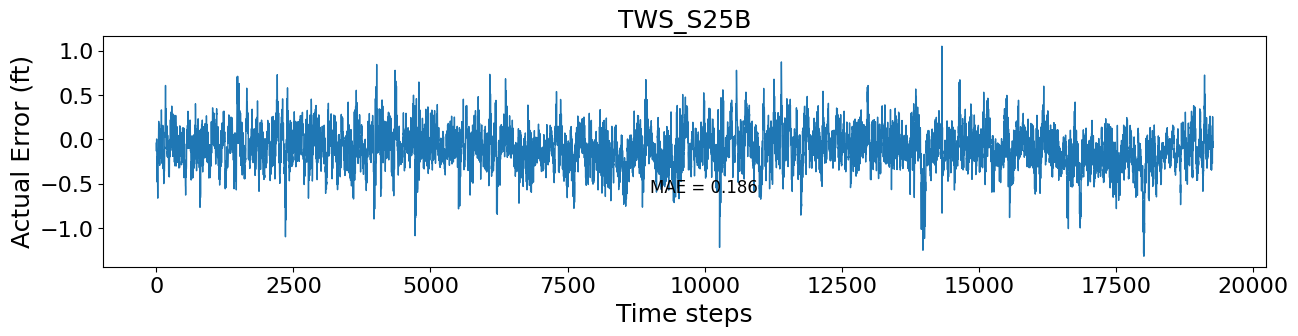

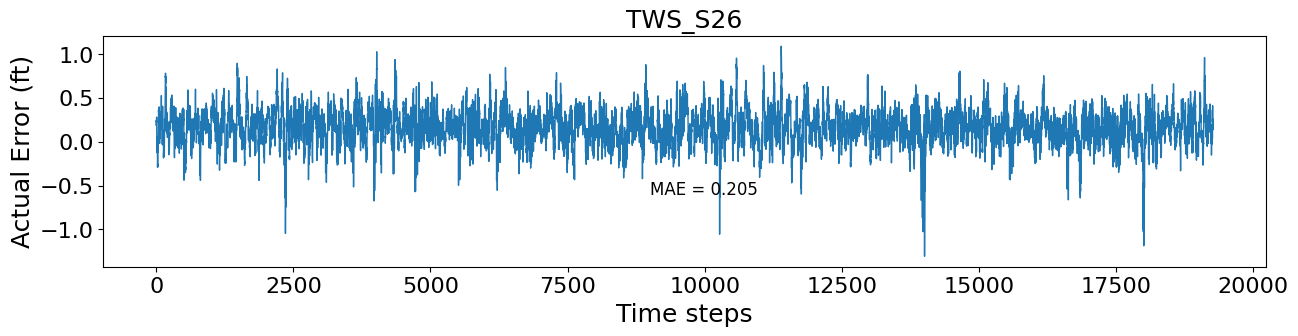

In [12]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [13]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
579
(19268,)
421
(19268,)
730
(19268,)
763


In [14]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
35
(19268,)
117
(19268,)
116
(19268,)
674


In [15]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
544
(19268,)
304
(19268,)
614
(19268,)
89
